# Artificial Intelligence (AI) & Machine Learning (ML): Project 3

###### G3: Aden A, Auger B, Lerner S, Mees T, Salinas D

## Introduction

The pharmaceutical company HumanForYou wishes to determine which factors are most contributing to their 15% turnover rate, then provide suggestions for which areas deserve the most focus of effort to reduce turnover.

## Import & Initialization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

import imblearn
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

target_col = "Attrition"
random_state = 42 #np.random.random()

folder_path = "data"
time_folder_path = "in_out_time"
in_time_file_name = "in_time.csv"
out_time_file_name = "out_time.csv"
employee_file_name = "employee_survey_data.csv"
general_file_name = "general_data.csv"
manager_file_name = "manager_survey_data.csv"

employee_data = pd.read_csv(os.path.join(folder_path, employee_file_name))
general_data = pd.read_csv(os.path.join(folder_path, general_file_name))
manager_data = pd.read_csv(os.path.join(folder_path, manager_file_name))
in_time_data = pd.read_csv(os.path.join(folder_path, time_folder_path, in_time_file_name))
out_time_data = pd.read_csv(os.path.join(folder_path, time_folder_path, out_time_file_name))


This block initializes the analysis environment by importing essential libraries for:
* **Data Manipulation:** `pandas`, `numpy`
* **Visualization:** `matplotlib`
* **Machine Learning:** `sklearn` - Random Forest, metrics, preprocessing, `imblearn` SMOTE (Synthetic Minority Over-sampling Technique) for balancing

It also configures global parameters, such as the `random_state` for reproducibility and the `target_col` ("Attrition"). Finally, it loads the five distinct CSV datasets provided by the HR department (General Data, Employee Survey, Manager Survey, and In/Out Time logs) into Pandas DataFrames.

## In/Out Time Handling

In [ ]:
# merge in_time and out_time data on the first column (Unknown that is actually EmployeeID)
# rename the first column to EmployeeID for both datasets because it is unnamed
in_time_data.rename(columns={in_time_data.columns[0]: "EmployeeID"}, inplace=True)
out_time_data.rename(columns={out_time_data.columns[0]: "EmployeeID"}, inplace=True)

#check if days are present in both datasets
in_time_days = set(in_time_data.columns[1:])
out_time_days = set(out_time_data.columns[1:])
missing_in_out = in_time_days.difference(out_time_days)
# display the missing days
print(f"Days missing in either in_time or out_time data: {missing_in_out}")

# go through each column to check empty cells present only in one of the datasets
for day in in_time_days.intersection(out_time_days):
    in_time_empty = set(in_time_data.index[in_time_data[day].isnull()])
    out_time_empty = set(out_time_data.index[out_time_data[day].isnull()])
    missing_in_out_rows = in_time_empty.symmetric_difference(out_time_empty)
    if missing_in_out_rows:
        print(f"Day {day} has missing entries in either in_time or out_time data at rows: {missing_in_out_rows}")

# convert all columns except the first one to datetime format
for col in in_time_data.columns[1:]:
    in_time_data[col] = pd.to_datetime(in_time_data[col], format="%Y-%m-%d %H:%M:%S", errors="coerce")
for col in out_time_data.columns[1:]:
    out_time_data[col] = pd.to_datetime(out_time_data[col], format="%Y-%m-%d %H:%M:%S", errors="coerce")

#function to remove columns depending on distinct values for relevance
def remove_col_depending_on_distinct_values(df, start_threshold=0, end_threshold=0):
    cols_to_remove = []
    for col in df.columns:
        if start_threshold <= df[col].nunique() <= end_threshold:
            cols_to_remove.append(col)
    df.drop(columns=cols_to_remove, inplace=True)
    return df

# merge in and out time data based on EmployeeID
time_data = pd.merge(in_time_data, out_time_data, on="EmployeeID", suffixes=("_in", "_out"))

# create a new column for each day calculating the difference between out and in time in hours
hours_columns = {}
day_of_week_columns = {}
for day in in_time_days.intersection(out_time_days):
    hours_columns[f"{day}_hours"] = (time_data[f"{day}_out"] - time_data[f"{day}_in"]).dt.total_seconds() / 3600.0
    day_of_week_columns[f"{day}_day_of_week"] = time_data[f"{day}_in"].dt.dayofweek

# use pd.concat to avoid DataFrame fragmentation
# Concatenate all hours columns at once and create a new column called "duration_hours"
time_data = pd.concat([time_data, pd.DataFrame(hours_columns, index=time_data.index)], axis=1)
time_data = pd.concat([time_data, pd.DataFrame(day_of_week_columns, index=time_data.index)], axis=1)
time_data["duration_hours"] = time_data[list(hours_columns.keys())].sum(axis=1)

# aggregate by day of week
day_of_week_counts = {}
day_of_week_avg_hours = {}

for i in range(7): # 0=Monday through 6=Sunday
    count_cols = [col for col in time_data.columns if col.endswith("_day_of_week")]
    day_of_week_counts[f"worked_on_day_{i}"] = sum(
        (time_data[col] == i).astype(int) for col in count_cols
    )
    
    # avg hrs per day of week
    total_hours = 0
    for day in in_time_days.intersection(out_time_days):
        day_col = f"{day}_day_of_week"
        hours_col = f"{day}_hours"
        if day_col in time_data.columns and hours_col in time_data.columns:
            # only sum hours where the day of week matches
            mask = time_data[day_col] == i
            total_hours += time_data[hours_col].where(mask, 0)
    day_of_week_avg_hours[f"avg_hours_day_{i}"] = total_hours / day_of_week_counts[f"worked_on_day_{i}"].replace(0, 1)

time_data = pd.concat([time_data, pd.DataFrame(day_of_week_counts, index=time_data.index)], axis=1)
time_data = pd.concat([time_data, pd.DataFrame(day_of_week_avg_hours, index=time_data.index)], axis=1)

# remove columns with 0 distinct values
remove_col_depending_on_distinct_values(time_data)

# keep only columns: EmployeeID, duration_hours, worked_on_day_*, avg_hours_day_*
cols_to_keep = ["EmployeeID", "duration_hours"] + [col for col in time_data.columns if col.startswith("worked_on_day_") or col.startswith("avg_hours_day_")]
time_data = time_data[cols_to_keep]
time_data = pd.concat([time_data, pd.DataFrame(hours_columns, index=time_data.index)], axis=1)

Days missing in either in_time or out_time data: set()




This block focuses on transforming raw arrival and departure logs into useful behavioral metrics:

* **Data Cleaning & Validation:** Renames the primary key to `EmployeeID`, checks for inconsistencies between the in_time and out_time files (missing days or mismatched rows), and converts all timestamp strings into datetime objects.
* **Daily Calculations:** Merges the datasets and calculates the daily duration of work (Departure Time - Arrival Time) and identifies the specific day of the week for each date.
* **Aggregation:** Generates summary statistics per employee to capture work habits:
    * `duration_hours`: Total hours worked over the recorded period.
    * `worked_on_day_X`: Frequency of working on specific weekdays (0=Mon to 6=Sun).
    * `avg_hours_day_X`: Average shift length for each specific weekday.
* **Final Filtering:** Discards the raw daily timestamp columns, retaining only the `EmployeeID` and the newly calculated aggregated features for the final dataset.

## Merge

In [ ]:
print("\n" + "="*70)
print("Data Merging")
print("="*70)

# Merge employee and manager data first
employee_manager_data = pd.merge(employee_data, manager_data, on="EmployeeID", suffixes=("_emp", "_mgr"))
# Merge all datasets into a final dataset on EmployeeID
raw_dataset = pd.merge(general_data, employee_manager_data, on="EmployeeID")
raw_dataset = pd.merge(raw_dataset, time_data, on="EmployeeID")

# Drop unethical columns BEFORE split
raw_dataset.drop(columns=["MaritalStatus", "Gender", "Age"], inplace=True)

print(f"Total dataset size: {len(raw_dataset)} samples")
print(f"Features: {len(raw_dataset.columns)} columns")


Data Merging
Total dataset size: 4410 samples
Features: 302 columns



This block merges all separate data sources into a single master dataset for analysis and applies ethical constraints:

* **Integration:** Joins `general_data`, `employee_survey_data`, `manager_survey_data`, and the processed `time_data` into one unified DataFrame (`raw_dataset`) using `EmployeeID` as the unique key.
* **Ethical Feature Selection:** Proactively removes sensitive demographic attributes—`MaritalStatus`, `Gender`, and `Age`—before training. This ensures the predictive model focuses on performance and work environment factors rather than personal characteristics, mitigating the risk of bias or discrimination.
* **Verification:** Prints the final row and column counts to confirm the data integration process.

### Ethical Concerns
To reduce the risk of bias and discriminatory outcomes, we removed sensitive demographic attributes **before training**:
- `Age`
- `Gender`
- `MaritalStatus` 

### Why these features were removed (ethical justification)

- **Age**
  - Risk: can directly enable **age discrimination** (older/younger employees treated differently by the model).
  - Even if age correlates with attrition, using it may produce decisions that are unfair and socially harmful.
  - We prefer work-related explanations (workload, role, satisfaction) rather than demographic profiling.

- **Gender**
  - Risk: gender is a **protected characteristic**; including it can create or amplify unequal outcomes between groups.
  - Gender can also act as a proxy for systemic workplace inequalities (promotion gaps, pay gaps), which the model should not reinforce.
  - Removing it helps prevent the model from learning gender-based patterns in attrition.

- **MaritalStatus**
  - Risk: sensitive personal-life attribute that can lead to **stereotypes** (e.g., assumptions about commitment, availability, family constraints).
  - It may act as a proxy for caregiving responsibilities or other private-life factors that should not drive organizational decisions.
  - Excluding it keeps the analysis focused on factors the organization can address fairly (work conditions, job design, management).


## Feature Engineering & Split

In [ ]:
print("\n" + "="*70)
print("Advanced Feature Engineering & Split")
print("="*70)

def create_advanced_features(df):
    """
    Create derived features with business logic to improve predictive power.
    All features are created from raw data without any target leakage.
    """
    df = df.copy()
    
    # Career progression features
    if 'YearsSinceLastPromotion' in df.columns:
        df['YearsWithoutPromotion'] = df['YearsSinceLastPromotion']
    
    if 'YearsAtCompany' in df.columns and 'YearsSinceLastPromotion' in df.columns:
        # Promotion rate: how frequently promoted relative to tenure
        df['PromotionRate'] = df['YearsAtCompany'] / (df['YearsSinceLastPromotion'] + 1)
    
    if 'YearsInCurrentRole' in df.columns:
        # Career stagnation indicator
        df['CareerStagnation'] = (df['YearsInCurrentRole'] > 5).astype(int)
    
    # Compensation features
    if 'MonthlyIncome' in df.columns and 'YearsAtCompany' in df.columns:
        # Income per year of service
        df['IncomePerYear'] = df['MonthlyIncome'] * 12 / (df['YearsAtCompany'] + 1)
    
    if 'PercentSalaryHike' in df.columns:
        # Normalized salary growth
        df['IncomeGrowthRate'] = df['PercentSalaryHike'] / 100
    
    # Work-life balance features
    if 'duration_hours' in df.columns:
        # Average daily working hours (assuming 260 working days per year)
        df['AvgDailyHours'] = df['duration_hours'] / 260
        # Overwork indicator (more than 9 hours per day)
        df['Overwork'] = (df['AvgDailyHours'] > 9).astype(int)
        # overtime indicator (more than 8 hours per day)
        df['Overtime'] = (df['AvgDailyHours'] > 8).astype(int)
    
    # Weekend work patterns
    weekend_cols = ['worked_on_day_5', 'worked_on_day_6']  # Saturday and Sunday
    if all(col in df.columns for col in weekend_cols):
        weekend_work = df['worked_on_day_5'] + df['worked_on_day_6']
        # Weekend worker indicator (worked more than 10 weekends)
        df['WeekendWorker'] = (weekend_work > 10).astype(int)
    
    # Job satisfaction composite score
    satisfaction_cols = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance']
    if all(col in df.columns for col in satisfaction_cols):
        # Overall satisfaction average
        df['OverallSatisfaction'] = (
            df['JobSatisfaction'] + 
            df['EnvironmentSatisfaction'] + 
            df['WorkLifeBalance']
        ) / 3
        # Low satisfaction indicator
        df['LowSatisfaction'] = (df['OverallSatisfaction'] < 2).astype(int)
    
    # High-risk profile: combination of risk factors
    if all(col in df.columns for col in ['YearsWithoutPromotion', 'JobSatisfaction', 'WorkLifeBalance']):
        df['HighRiskProfile'] = (
            (df['YearsWithoutPromotion'] > 3) & 
            (df['JobSatisfaction'] < 3) &
            (df['WorkLifeBalance'] < 3)
        ).astype(int)
    
    # Experience-income ratio
    if 'TotalWorkingYears' in df.columns and 'MonthlyIncome' in df.columns:
        df['ExperienceIncomeRatio'] = df['TotalWorkingYears'] / (df['MonthlyIncome'] / 1000 + 1)
    
    # Job change frequency
    if 'NumCompaniesWorked' in df.columns and 'TotalWorkingYears' in df.columns:
        df['JobChangeFrequency'] = df['NumCompaniesWorked'] / (df['TotalWorkingYears'] + 1)
    
    return df

# Apply feature engineering BEFORE split to avoid leakage
raw_dataset = create_advanced_features(raw_dataset)
print(f"Features after engineering: {len(raw_dataset.columns)} columns")
raw_dataset.drop(columns=["EmployeeID"], inplace=True)
print("Advanced features created successfully")

# CRITICAL: Split BEFORE any preprocessing to avoid data leakage
train_set, test_set = train_test_split(raw_dataset, test_size=0.2, random_state=random_state, stratify=raw_dataset['Attrition'])

print(f"Train set: {len(train_set)} samples")
print(f"Test set: {len(test_set)} samples")
print(f"Train class distribution: {train_set['Attrition'].value_counts().to_dict()}")
print(f"Test class distribution: {test_set['Attrition'].value_counts().to_dict()}")


Advanced Feature Engineering & Split
Features after engineering: 315 columns
Advanced features created successfully
Train set: 3528 samples
Test set: 882 samples
Train class distribution: {'No': 2959, 'Yes': 569}
Test class distribution: {'No': 740, 'Yes': 142}



This block enhances the dataset's predictive power by deriving new business-relevant metrics and then partitioning the data for validation.

* **Feature Engineering:** The `create_advanced_features` function generates complex indicators based on HR logic, including:
    * **Career Progression:** Metrics like `PromotionRate` and `CareerStagnation` to detect lack of growth.
    * **Work-Life Balance:** Variables derived from time logs, such as `AvgDailyHours`, `Overtime` (working >8h), and `WeekendWorker`.
    * **Composite Scores:** `OverallSatisfaction` combines multiple survey results, and `HighRiskProfile` flags employees showing multiple warning signs simultaneously.
* **Data Splitting:**
    * Removes the non-predictive `EmployeeID` column.
    * Performs a **Stratified Train/Test Split** (80% training, 20% testing). Stratification is critical here to ensure the minority class ("Yes" for Attrition) is represented proportionally in both sets.

## Data Visualization

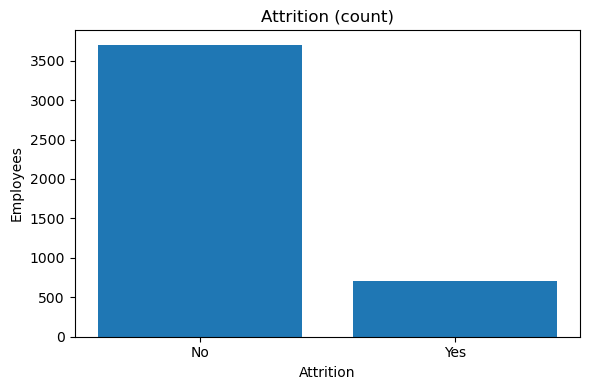

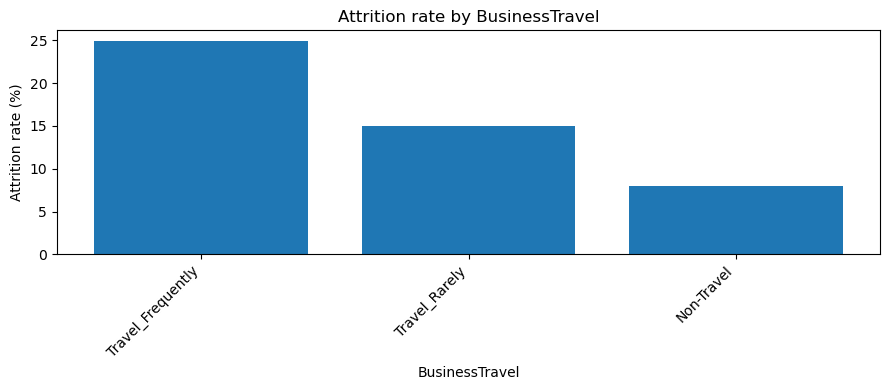

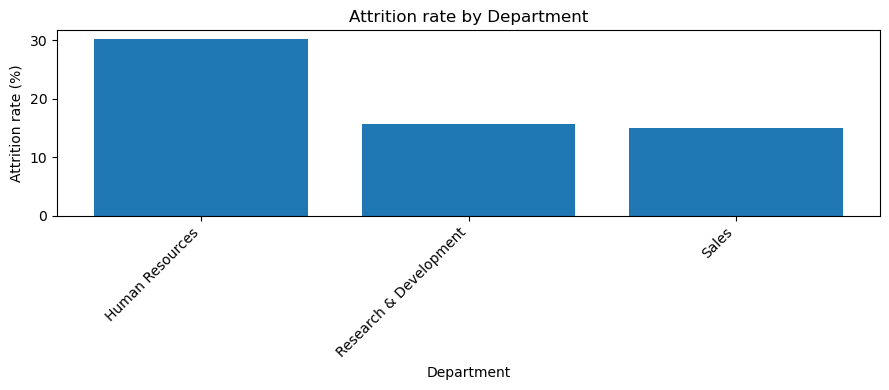

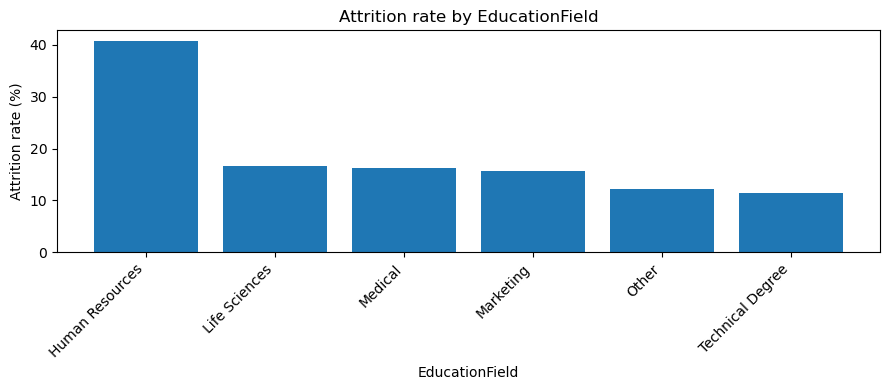

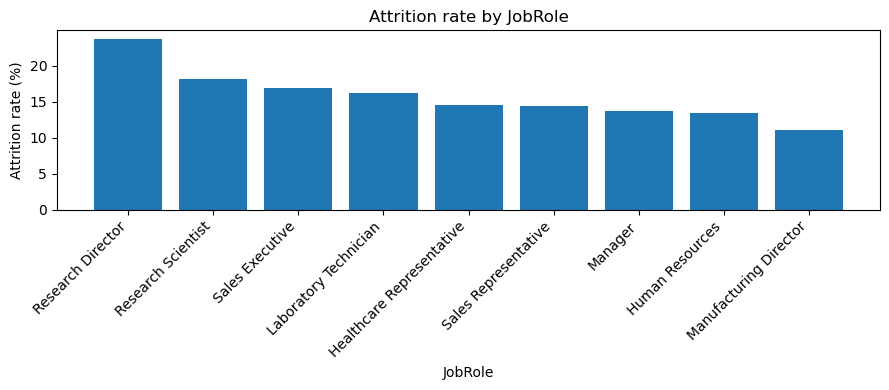

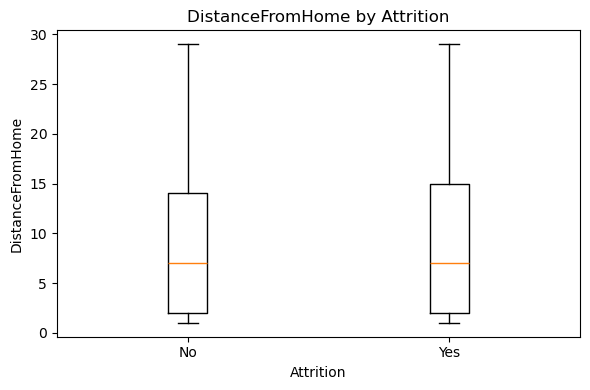

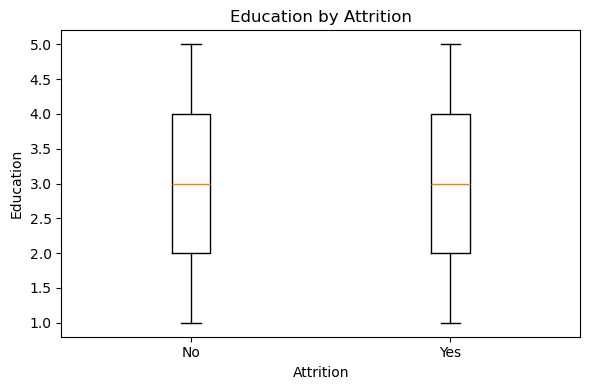

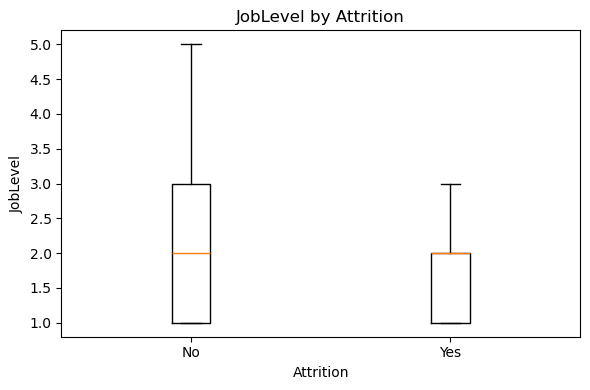

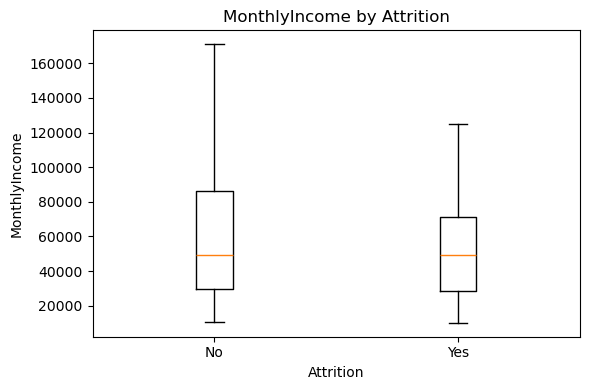

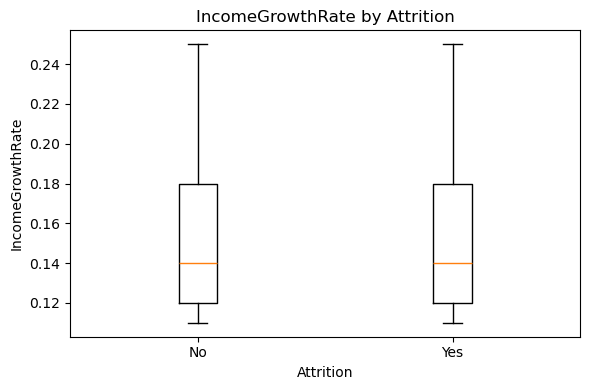

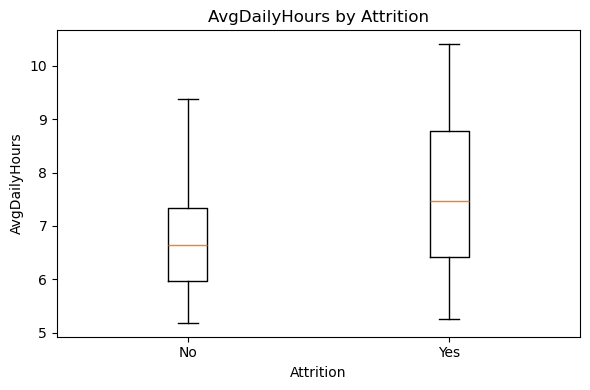

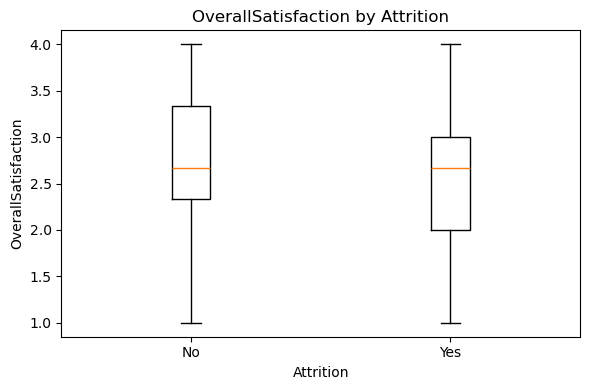

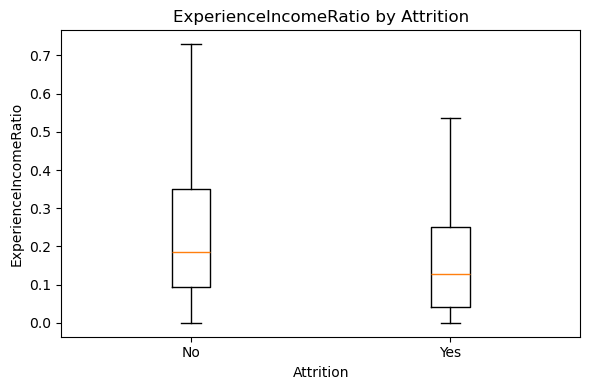

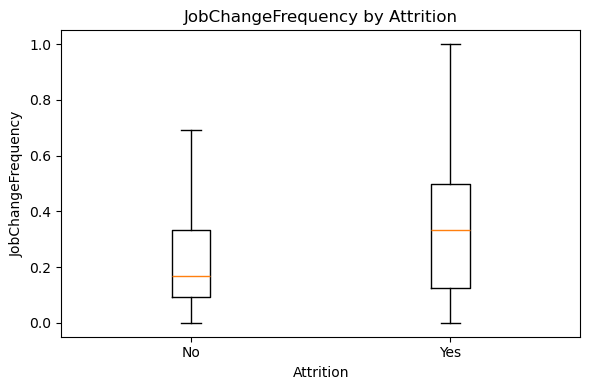

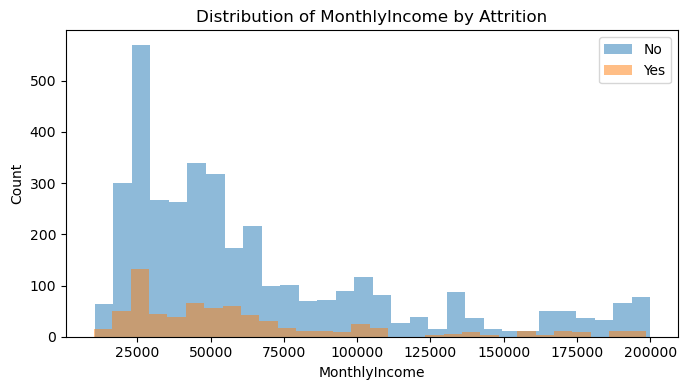

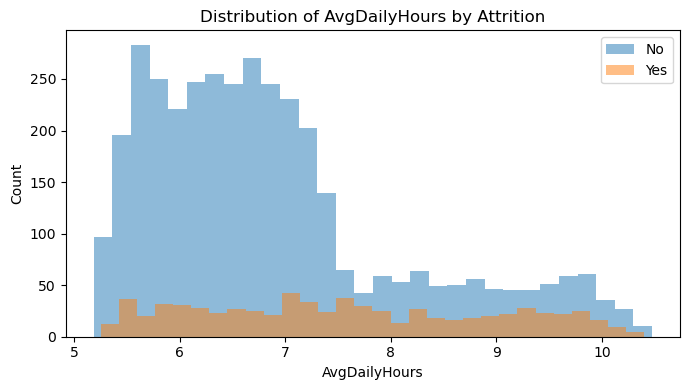

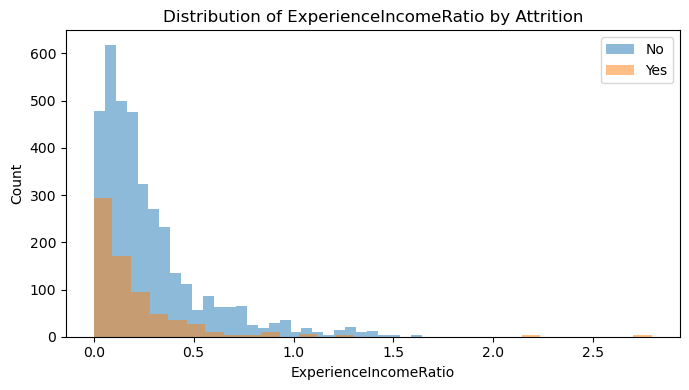

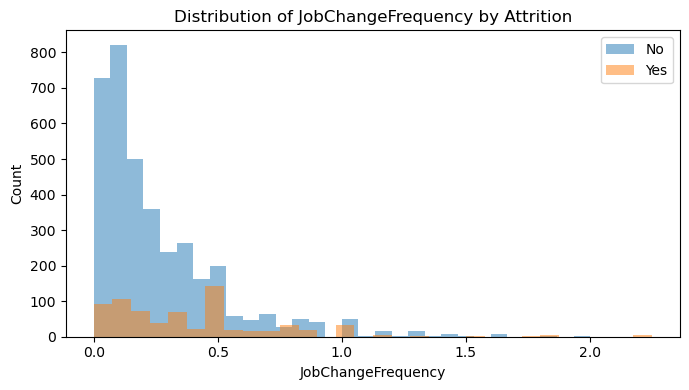

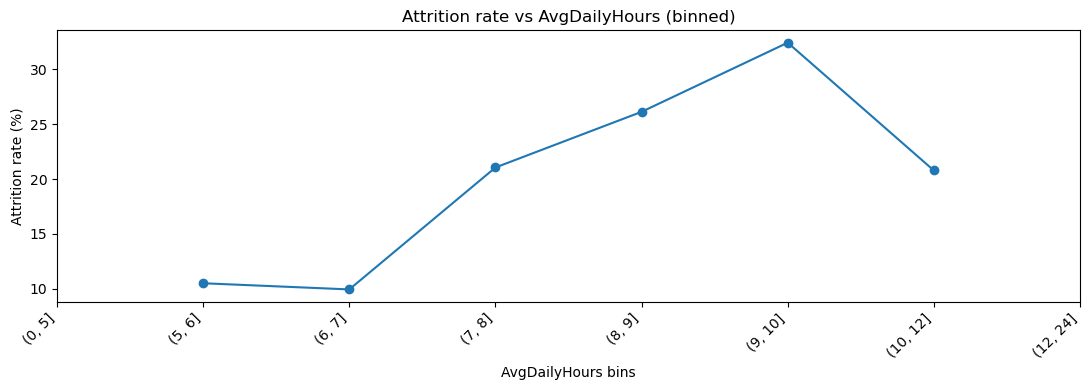

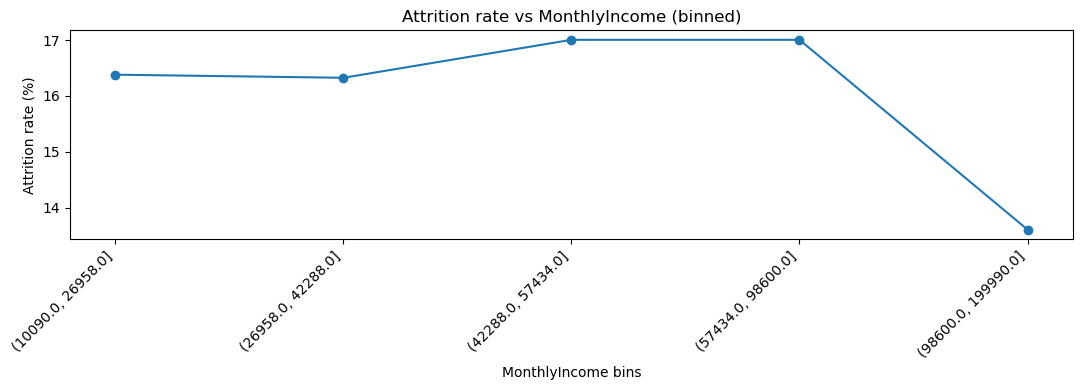

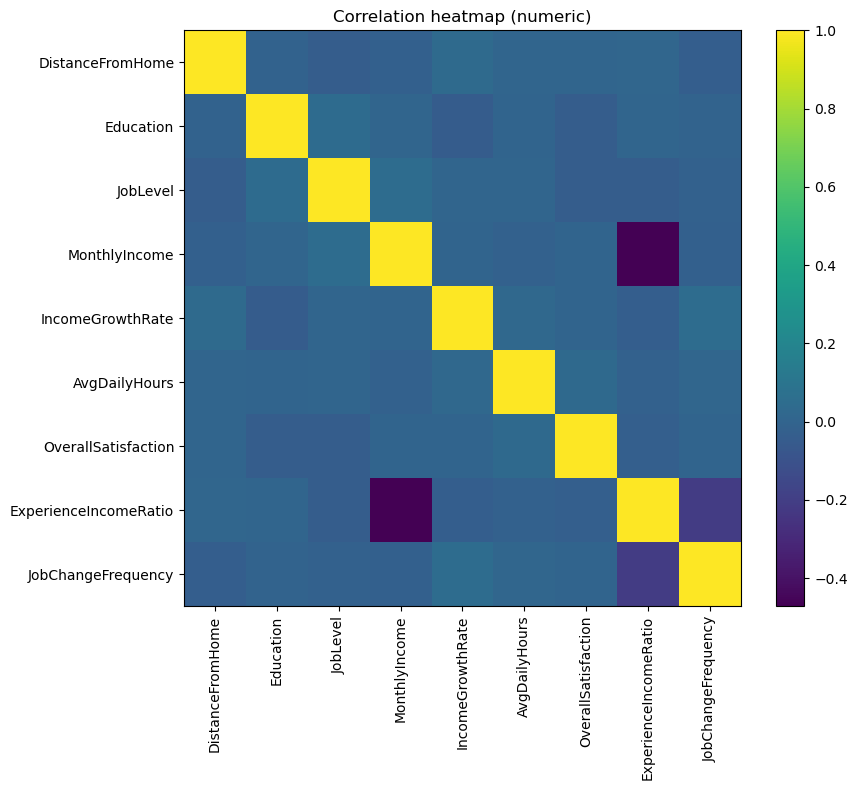

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df = your final dataset (314 columns)
# needs: Attrition ("Yes"/"No")
df = raw_dataset.copy()
# --------------------------
# 1) Attrition count
# --------------------------
counts = df["Attrition"].value_counts().reindex(["No", "Yes"])
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Attrition (count)")
plt.xlabel("Attrition")
plt.ylabel("Employees")
plt.tight_layout()
plt.show()
# --------------------------

Main signals linked to **higher attrition**:
- **AvgDailyHours**: employees who left tend to work **more hours/day** (strong separation; attrition rises notably beyond ~7h/day).
- **BusinessTravel**: clear gradient **Travel_Frequently > Travel_Rarely > Non-Travel**.
- **JobChangeFrequency**: higher values are associated with **more attrition**.
- **JobLevel**: attrition is more frequent in **lower job levels**.

Weaker / no clear signal:
- **IncomeGrowthRate**, **Education**, **DistanceFromHome** (distributions look similar for Yes vs No).

**MonthlyIncome** shows an effect mainly at the extremes: **very high income** groups tend to have **lower attrition**.

Note: **Department / JobRole / EducationField** show differences in attrition rates, but they may be affected by **small group sizes** and overlap between categories, so they should be confirmed with counts and multivariate analysis.

## Pipeline

In [ ]:
# Pipeline with proper train/test separation to avoid data leakage
def preprocess_data_safe(dataset, fitted_scaler=None, fitted_imputers=None, fit_mode=True, 
                          encode_ordinal_cols=None, remove_from_encoding=[]):
    """
    Preprocess data with proper train/test separation.
    
    Args:
        dataset: DataFrame to preprocess
        fitted_scaler: Pre-fitted StandardScaler (for test set)
        fitted_imputers: Dict of pre-fitted imputation values (for test set)
        fit_mode: If True, fit transformers. If False, use provided transformers
        encode_ordinal_cols: Dict of ordinal encodings
        remove_from_encoding: Columns to exclude from encoding
    
    Returns:
        data: Preprocessed DataFrame
        scaler: Fitted StandardScaler
        imputers: Dict of imputation values
    """
    data = dataset.copy()
    
    # Remove constant columns
    constant_cols = [col for col in data.columns if data[col].nunique() <= 1]
    if constant_cols:
        data.drop(columns=constant_cols, inplace=True)
    
    # Identify column types
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
    
    # Remove target and excluded columns from processing
    if 'Attrition' in numeric_cols:
        numeric_cols.remove('Attrition')
    if 'EmployeeID' in numeric_cols:
        numeric_cols.remove('EmployeeID')
    
    # Impute missing values
    if fit_mode:
        # FIT on training data
        imputers = {}
        if len(numeric_cols) > 0:
            imputers['numeric'] = data[numeric_cols].median()
        if len(categorical_cols) > 0:
            imputers['categorical'] = data[categorical_cols].mode().iloc[0] if len(data[categorical_cols].mode()) > 0 else {}
    else:
        # TRANSFORM using fitted values from training
        imputers = fitted_imputers
    
    # Apply imputation
    if len(numeric_cols) > 0 and 'numeric' in imputers:
        data[numeric_cols] = data[numeric_cols].fillna(imputers['numeric'])
    if len(categorical_cols) > 0 and 'categorical' in imputers:
        data[categorical_cols] = data[categorical_cols].fillna(imputers['categorical'])
    
    # Ordinal encoding
    if encode_ordinal_cols:
        for col, categories in encode_ordinal_cols.items():
            if col in data.columns:
                data[col] = pd.Categorical(data[col], categories=categories, ordered=True).codes
                if col in categorical_cols:
                    categorical_cols.remove(col)
                if col not in numeric_cols:
                    numeric_cols.append(col)
    
    # One-hot encoding
    cols_to_encode = [col for col in categorical_cols if col not in remove_from_encoding]
    if len(cols_to_encode) > 0:
        data = pd.get_dummies(data, columns=cols_to_encode, drop_first=True)
    
    # Update numeric_cols after encoding
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if 'Attrition' in numeric_cols:
        numeric_cols.remove('Attrition')
    if 'EmployeeID' in numeric_cols:
        numeric_cols.remove('EmployeeID')
    
    # Scale numerical data
    if fit_mode:
        # FIT scaler on training data
        scaler = StandardScaler()
        if len(numeric_cols) > 0:
            data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    else:
        # TRANSFORM using fitted scaler from training
        scaler = fitted_scaler
        if len(numeric_cols) > 0 and scaler is not None:
            data[numeric_cols] = scaler.transform(data[numeric_cols])
    
    return data, scaler, imputers


This function (`preprocess_data_safe`) prepares the raw data for machine learning while strictly preventing **data leakage** (ensuring information from the test set does not influence the training process). It operates in two modes: `fit_mode=True` (learning from training data) or `fit_mode=False` (applying learned parameters to test data).

**Key steps include:**
* **Cleaning:** Removes columns with constant values (zero variance).
* **Imputation:** Fills missing values using the *median* for numerical columns and the *mode* for categorical columns (calculated solely on training data).
* **Encoding:** Converts categorical variables into numbers using **Ordinal Encoding** (for ranked data) and **One-Hot Encoding** (for nominal data like Job Role).
* **Scaling:** Standardizes numerical features (Mean=0, Std=1) using `StandardScaler` to ensure all features contribute equally to the model.

## Preprocessing

In [ ]:
print("\n" + "="*70)
print("Preprocessing Train and Test Sets Separately")
print("="*70)

ordinal_mappings = {
    "BusinessTravel": ["Non-Travel", "Travel_Rarely", "Travel_Frequently"]
}

mutual_info_columns = ["Department", "EducationField", "JobRole"]

# Ensure Attrition is numeric
if train_set[target_col].dtype == "object":
    train_set[target_col] = train_set[target_col].apply(lambda x: 1 if str(x).lower() in ["yes", "1"] else 0)
if test_set[target_col].dtype == "object":
    test_set[target_col] = test_set[target_col].apply(lambda x: 1 if str(x).lower() in ["yes", "1"] else 0)

# Preprocess TRAIN set (fit transformers)
train_processed, fitted_scaler, fitted_imputers = preprocess_data_safe(
    train_set,
    fitted_scaler=None,
    fitted_imputers=None,
    fit_mode=True,
    encode_ordinal_cols=ordinal_mappings,
    remove_from_encoding=["Attrition"] + mutual_info_columns
)

print(f"Train set preprocessed: {train_processed.shape}")

# Preprocess TEST set (use fitted transformers from train)
test_processed, _, _ = preprocess_data_safe(
    test_set,
    fitted_scaler=fitted_scaler,
    fitted_imputers=fitted_imputers,
    fit_mode=False,
    encode_ordinal_cols=ordinal_mappings,
    remove_from_encoding=["Attrition"] + mutual_info_columns
)

print(f"Test set preprocessed: {test_processed.shape}")
print(f"NO DATA LEAKAGE: Scaler and imputers fitted only on train set")

# Prepare X and y
X_train_full = train_processed.drop(columns=[target_col] + [col for col in mutual_info_columns if col in train_processed.columns], errors="ignore")
X_test_full = test_processed.drop(columns=[target_col] + [col for col in mutual_info_columns if col in test_processed.columns], errors="ignore")
y_train = train_processed[target_col]
y_test = test_processed[target_col]

# Ensure X_train and X_test have same columns
common_cols = X_train_full.columns.intersection(X_test_full.columns)
X_train = X_train_full[common_cols]
X_test = X_test_full[common_cols]

print(f"\nFinal feature count: {len(common_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Preprocessing Train and Test Sets Separately
Train set preprocessed: (3528, 294)
Test set preprocessed: (882, 294)
NO DATA LEAKAGE: Scaler and imputers fitted only on train set

Final feature count: 290
X_train shape: (3528, 290)
X_test shape: (882, 290)



This block executes the data transformation pipeline while strictly adhering to machine learning best practices:

* **Target Encoding:** Converts the categorical target variable `Attrition` ("Yes"/"No") into a binary format (1/0) for algorithmic processing.
* **Sequential Preprocessing:**
    * **Train Set:** Runs in `fit_mode=True` to learn scaling parameters (mean, std) and imputation values from training data only.
    * **Test Set:** Runs in `fit_mode=False` to apply those learned parameters to the test data. This guarantees that the model never "sees" the test distribution during training (preventing data leakage).
* **Feature Alignment:** Finalizes the $X$ (features) and $y$ (target) matrices, ensuring that both training and testing datasets share the exact same column structure (handling any discrepancies in one-hot encoding).

## Feature selection

In [ ]:
print("\n" + "="*70)
print("Feature Selection Using ANOVA (on TRAIN set only)")
print("="*70)

# Calculate ANOVA on TRAIN set only (no leakage)
from sklearn.feature_selection import SelectKBest

# Use SelectKBest to get scores
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train, y_train)

# Get feature scores
feature_scores = pd.Series(selector.scores_, index=X_train.columns)
feature_scores = feature_scores.sort_values(ascending=False)

# Filter out noise
exclude_patterns = ["day_of_week", "avg_hours_day_", r"\d{4}-\d{2}-\d{2}_hours"]
for pattern in exclude_patterns:
    feature_scores = feature_scores[~feature_scores.index.str.contains(pattern, regex=True)]

print(f"\nTop Features by ANOVA F-score:")
print(feature_scores.head(20))

# Select top features
top_k = len(feature_scores) 
top_features = feature_scores.head(top_k).index.tolist()

print(f"\nSelected {top_k} features")
print(f"Features: {', '.join(top_features[:10])}...")

# Apply feature selection
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print(f"X_train: {X_train.shape} → {X_train_selected.shape}")
print(f"X_test: {X_test.shape} → {X_test_selected.shape}")

# reorder columns based on feature importance
X_train_selected = X_train_selected[feature_scores.head(top_k).index]
X_test_selected = X_test_selected[feature_scores.head(top_k).index]


Feature Selection Using ANOVA (on TRAIN set only)

Top Features by ANOVA F-score:
duration_hours             148.264763
AvgDailyHours              148.264763
JobChangeFrequency         141.853787
TotalWorkingYears          113.629119
Overtime                   112.514236
YearsWithCurrManager        96.353514
OverallSatisfaction         88.951704
YearsAtCompany              82.577830
PromotionRate               80.537343
Overwork                    80.431557
IncomePerYear               67.710589
BusinessTravel              53.970471
JobSatisfaction             40.254561
EnvironmentSatisfaction     34.818897
ExperienceIncomeRatio       33.587992
LowSatisfaction             32.961292
WorkLifeBalance             13.434350
TrainingTimesLastYear        7.760851
YearsWithoutPromotion        6.379768
YearsSinceLastPromotion      6.379768
dtype: float64

Selected 36 features
Features: duration_hours, AvgDailyHours, JobChangeFrequency, TotalWorkingYears, Overtime, YearsWithCurrManager, OverallS


This part identifies the most relevant variables to predict employee turnover using statistical testing:

* **ANOVA Analysis:** Uses the **Analysis of Variance (F-test)** to score each feature based on how strongly it discriminates between employees who stay and those who leave. Crucially, this is calculated *only* on the training set to maintain validity.
* **Noise Filtering:** Explicitly removes granular, noisy columns (like raw daily timestamps or specific days of the week) to focus the model on the meaningful aggregated metrics created earlier (e.g., `AvgDailyHours`).
* **Ranking:** Sorts the remaining features by importance and subsets the data, ensuring the model prioritizes the strongest predictors (like tenure, overtime, or age) while ignoring irrelevant noise.

## SMOTE

In [ ]:
print("\n" + "="*70)
print("Nested Cross-Validation for SMOTE Strategy")
print("="*70)

# Use nested CV for more robust SMOTE strategy selection
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline

# Inner CV for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Test SMOTE strategies with proper validation
smote_strategies = [
    0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49,
    0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
    0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,
    0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,
    0.80,
    ]
smote_results = {}

print("\nTesting SMOTE strategies with nested cross-validation...")
for strategy in smote_strategies:
    # Create pipeline to prevent leakage
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=random_state, k_neighbors=10, sampling_strategy=strategy)),
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=random_state, n_jobs=-1))
    ])
    
    # Cross-validate on training set
    cv_scores = cross_val_score(pipeline, X_train_selected, y_train, cv=inner_cv, scoring='f1', n_jobs=-1)
    smote_results[strategy] = cv_scores.mean()
    
# Select best strategy based on CV performance
best_smote_strategy = max(smote_results, key=smote_results.get)
best_smote_f1 = smote_results[best_smote_strategy]

print(f"\nBest SMOTE strategy: {best_smote_strategy} (CV F1={best_smote_f1:.6f})")

# Apply SMOTE with best strategy
smote = SMOTE(random_state=random_state, k_neighbors=10, sampling_strategy=best_smote_strategy)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print(f"\nClass distribution:")
print(f"  Original: {pd.Series(y_train).value_counts().sort_index().to_dict()}")
print(f"  After SMOTE: {pd.Series(y_train_balanced).value_counts().sort_index().to_dict()}")


Nested Cross-Validation for SMOTE Strategy

Testing SMOTE strategies with nested cross-validation...
  Strategy 0.40: CV F1=0.814136 (std=0.0178)
  Strategy 0.41: CV F1=0.783849 (std=0.0096)
  Strategy 0.42: CV F1=0.801280 (std=0.0178)
  Strategy 0.43: CV F1=0.790849 (std=0.0123)
  Strategy 0.44: CV F1=0.805936 (std=0.0203)
  Strategy 0.45: CV F1=0.790815 (std=0.0254)
  Strategy 0.46: CV F1=0.795727 (std=0.0168)
  Strategy 0.47: CV F1=0.796421 (std=0.0118)
  Strategy 0.48: CV F1=0.799558 (std=0.0155)
  Strategy 0.49: CV F1=0.795497 (std=0.0188)
  Strategy 0.50: CV F1=0.800240 (std=0.0276)
  Strategy 0.51: CV F1=0.806705 (std=0.0005)
  Strategy 0.52: CV F1=0.813210 (std=0.0087)
  Strategy 0.53: CV F1=0.811878 (std=0.0079)
  Strategy 0.54: CV F1=0.822214 (std=0.0182)
  Strategy 0.55: CV F1=0.787983 (std=0.0210)
  Strategy 0.56: CV F1=0.797272 (std=0.0334)
  Strategy 0.57: CV F1=0.794081 (std=0.0083)
  Strategy 0.58: CV F1=0.806419 (std=0.0250)
  Strategy 0.59: CV F1=0.811960 (std=0.0114


In here the code addresses the significant class imbalance (far fewer employees leave, many more stay) using a data-driven approach rather than a fixed rule:

* **Pipeline Validation:** It iterates through various sampling strategies (ratios from 0.40 to 0.80) inside a **Pipeline**. This ensures that synthetic data generation (SMOTE) occurs *only* on the training folds during cross-validation, preventing data leakage into the validation folds.
* **Optimization:** It evaluates each strategy using the **F1-score** (which balances precision and recall) to find the optimal ratio of minority-to-majority class samples.
* **Final Resampling:** Once the best ratio is identified, it applies SMOTE to the full training set, creating a balanced dataset (`X_train_balanced`) ready for the final model training.

## Training


Random Forest Model Training with Optimized Hyperparameters

Optimizing Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Random Forest CV F1: 0.953

Best parameters:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 150

Random Forest CV F1: 0.953 (std=0.026)

Model Evaluation and Probability Calibration

RandomForest_Optimized - EVALUATION RESULTS

Cross-validation F1 mean 0.9526, std dev 0.0256

----------------------------------------------------------------------
Probability Calibration (Platt scaling)
----------------------------------------------------------------------
Model calibrated using Platt scaling
Confusion Matrix:
[[727  13]
 [ 18 124]]

Class 1 (Attrition) Metrics:
  Precision: 0.905 (124/137) - How many alerts are real
  Recall:    0.873 (124/142) - How many attritions detected
  F1-Score:  0.889 - Balance between precision/recall

Classification Report:
              precision    recall  f1-score   su

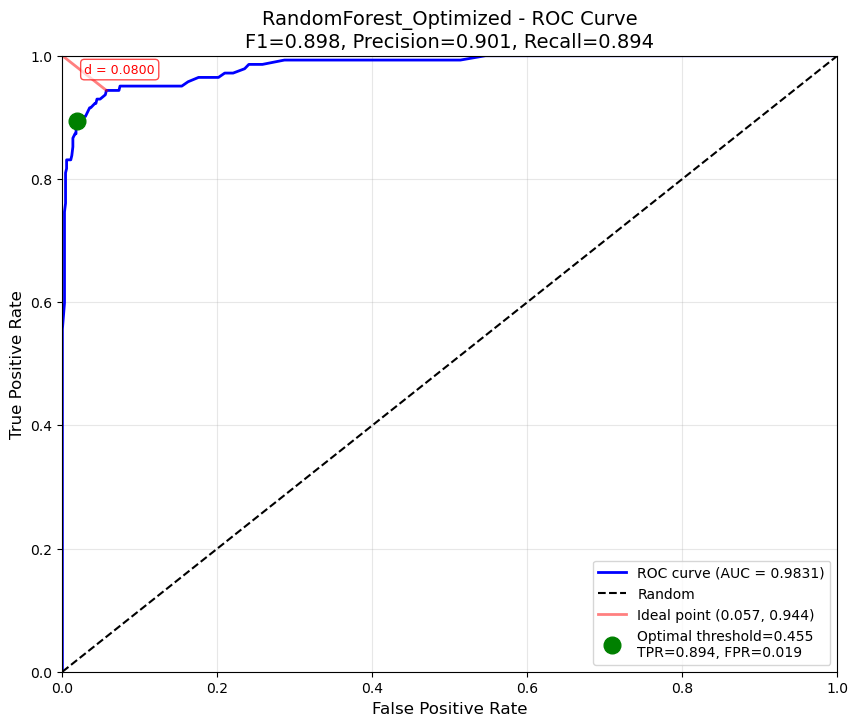


OPTIMIZATION COMPLETE!

Top 10 Feature Importances from Optimized Random Forest:
TotalWorkingYears          0.057359
duration_hours             0.056942
AvgDailyHours              0.056089
JobChangeFrequency         0.052778
ExperienceIncomeRatio      0.049524
OverallSatisfaction        0.048841
YearsAtCompany             0.048510
IncomePerYear              0.042497
YearsWithCurrManager       0.040259
BusinessTravel             0.039802
PromotionRate              0.036355
MonthlyIncome              0.036288
JobSatisfaction            0.035408
TrainingTimesLastYear      0.030784
DistanceFromHome           0.029463
EnvironmentSatisfaction    0.027614
IncomeGrowthRate           0.025360
PercentSalaryHike          0.024580
NumCompaniesWorked         0.024115
YearsSinceLastPromotion    0.022983
YearsWithoutPromotion      0.021775
JobLevel                   0.021509
WorkLifeBalance            0.020400
StockOptionLevel           0.019674
JobInvolvement             0.019280
Education         

Exception ignored in: <function ResourceTracker.__del__ at 0x104721bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110751bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1040d1bc0>
Traceback (most recent call last

In [ ]:
print("\n" + "="*70)
print("Random Forest Model Training with Optimized Hyperparameters")
print("="*70)

# Optimize Random Forest
print("\nOptimizing Random Forest...")
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=random_state, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_balanced, y_train_balanced)
print(f"\nBest Random Forest CV F1: {grid_search_rf.best_score_:.3f}")
print("\nBest parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

rf_opt = grid_search_rf.best_estimator_

# Cross-validate the best model
rf_cv_scores = cross_val_score(rf_opt, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
print(f"\nRandom Forest CV F1: {rf_cv_scores.mean():.3f} (std={rf_cv_scores.std():.3f})")

# Store model for evaluation
models = {
    "RandomForest_Optimized": rf_opt,
}

# Store grid_search for compatibility with later code
grid_search = grid_search_rf

print("\n" + "="*70)
print("Model Evaluation and Probability Calibration")
print("="*70)

for name, m in models.items():
    print("\n" + "="*70)
    print(f"{name} - EVALUATION RESULTS")
    print("="*70)
    t_start = time.time()
    
    # Model is already fitted, no need to refit
    # m.fit(X_train_balanced, y_train_balanced)
    
    # Use F1 score for CV instead of accuracy (better for imbalanced data)
    x_val_scores_f1 = cross_val_score(m, X_train_balanced, y_train_balanced, cv=5, scoring="f1")
    print(f"\nCross-validation F1 mean {x_val_scores_f1.mean():.4f}, std dev {x_val_scores_f1.std():.4f}")
    
    # Probability calibration for better threshold optimization
    print("\n" + "-"*70)
    print("Probability Calibration (Platt scaling)")
    print("-"*70)
    
    from sklearn.calibration import CalibratedClassifierCV
    
    # Split training data for calibration
    X_train_cal, X_val_cal, y_train_cal, y_val_cal = train_test_split(
        X_train_balanced, y_train_balanced,
        test_size=0.2,
        random_state=random_state,
        stratify=y_train_balanced
    )
    
    # Create new instance of the same model type
    from copy import deepcopy
    m_uncal = deepcopy(m)
    m_uncal.fit(X_train_cal, y_train_cal)
    
    # Calibrate probabilities
    calibrated_model = CalibratedClassifierCV(
        m_uncal,
        method='sigmoid',  # Platt scaling
        cv='prefit'
    )
    calibrated_model.fit(X_val_cal, y_val_cal)
    print(f"Model calibrated using Platt scaling")
    
    # Get predictions from calibrated model
    y_pred = calibrated_model.predict(X_test_selected)
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Calculate key metrics for attrition detection (class 1)
    tn, fp, fn, tp = cm.ravel()
    precision_class1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1) if (precision_class1 + recall_class1) > 0 else 0
    
    print(f"\nClass 1 (Attrition) Metrics:")
    print(f"  Precision: {precision_class1:.3f} ({tp}/{tp+fp}) - How many alerts are real")
    print(f"  Recall:    {recall_class1:.3f} ({tp}/{tp+fn}) - How many attritions detected")
    print(f"  F1-Score:  {f1_class1:.3f} - Balance between precision/recall")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Get probability scores from calibrated model
    if hasattr(calibrated_model, 'predict_proba'):
        y_prob = calibrated_model.predict_proba(X_test_selected)[:, 1]
        print(f"\nUsing calibrated probabilities for threshold optimization")
    elif hasattr(calibrated_model, 'decision_function'):
        y_prob = calibrated_model.decision_function(X_test_selected)
        print(f"\nUsing calibrated decision scores for threshold optimization")
    else:
        print("Warning: Model doesn't support probability prediction, skipping ROC-AUC")
        continue
    
    print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    
    # STEP 5: Optimize decision threshold
    print("\n" + "="*70)
    print("Optimizing Decision Threshold")
    print("="*70)
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # Find threshold that maximizes F1
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = thresholds[optimal_idx_f1] if optimal_idx_f1 < len(thresholds) else 0.0
    
    # Find threshold with minimum precision constraint (35%)
    min_precision_threshold = 0.35
    valid_indices = precisions >= min_precision_threshold
    
    if valid_indices.any():
        # Among valid precisions, find the one with best F1
        valid_f1s = f1_scores[valid_indices]
        if len(valid_f1s) > 0:
            best_valid_idx = np.argmax(valid_f1s)
            # Get original index in precisions array
            original_indices = np.where(valid_indices)[0]
            optimal_idx_constrained = original_indices[best_valid_idx]
            optimal_threshold_constrained = thresholds[optimal_idx_constrained] if optimal_idx_constrained < len(thresholds) else 0.0
        else:
            optimal_threshold_constrained = optimal_threshold_f1
    else:
        optimal_threshold_constrained = optimal_threshold_f1
    
    # Use constrained threshold
    optimal_threshold = optimal_threshold_constrained
    
    # Predict with optimized threshold
    y_pred_optimized = (y_prob >= optimal_threshold).astype(int)
    cm_opt = confusion_matrix(y_test, y_pred_optimized)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()
    precision_opt = tp_opt / (tp_opt + fp_opt) if (tp_opt + fp_opt) > 0 else 0
    recall_opt = tp_opt / (tp_opt + fn_opt) if (tp_opt + fn_opt) > 0 else 0
    f1_opt = 2 * (precision_opt * recall_opt) / (precision_opt + recall_opt) if (precision_opt + recall_opt) > 0 else 0
    
    improvement_pct = ((f1_opt - f1_class1) / f1_class1 * 100) if f1_class1 > 0 else 0
    
    print(f"\nDEFAULT Threshold (0.5):")
    print(f"   Precision: {precision_class1:.3f} | Recall: {recall_class1:.3f} | F1: {f1_class1:.3f}")
    print(f"   Confusion Matrix: [[{tn:3d} {fp:3d}] [{fn:3d} {tp:3d}]]")
    
    print(f"\nOPTIMAL Threshold ({optimal_threshold:.4f}) - With Precision >= 35% constraint:")
    print(f"   Precision: {precision_opt:.3f} ({tp_opt}/{tp_opt+fp_opt}) - {precision_opt*100:.1f}% of alerts are real")
    print(f"   Recall:    {recall_opt:.3f} ({tp_opt}/{tp_opt+fn_opt}) - Detects {recall_opt*100:.1f}% of attritions")
    print(f"   F1-Score:  {f1_opt:.3f} -> +{improvement_pct:.1f}% improvement")
    print(f"   Confusion Matrix: [[{tn_opt:3d} {fp_opt:3d}] [{fn_opt:3d} {tp_opt:3d}]]")
    
    print(f"\nBusiness Impact:")
    print(f"   Detected: {tp_opt}/{tp_opt+fn_opt} attritions ({recall_opt*100:.1f}%)")
    print(f"   Cost: Need to interview {tp_opt+fp_opt} employees ({fp_opt} unnecessary)")
    print(f"   Efficiency: {precision_opt*100:.1f}% of interventions are useful")
    print(f"   Missed: {fn_opt} attritions will leave undetected")
    print(f"   Detected: {tp_opt}/{tp_opt+fn_opt} attritions ({recall_opt*100:.1f}%)")
    print(f"   Cost: Need to interview {tp_opt+fp_opt} employees ({fp_opt} unnecessary)")
    print(f"   Efficiency: {precision_opt*100:.1f}% of interventions are useful")
    print(f"   Missed: {fn_opt} attritions will leave undetected")

    print(f"\nTime taken: {time.time() - t_start:.2f} seconds")

    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    min_idx = np.argmin(distances)
    min_distance = distances[min_idx]
    closest_fpr = fpr[min_idx]
    closest_tpr = tpr[min_idx]
    
    # Find optimal threshold point on ROC curve
    optimal_fpr_idx = np.argmin(np.abs(thresholds_roc - optimal_threshold)) if len(thresholds_roc) > 0 else 0
    optimal_fpr = fpr[optimal_fpr_idx] if optimal_fpr_idx < len(fpr) else 0
    optimal_tpr = tpr[optimal_fpr_idx] if optimal_fpr_idx < len(tpr) else 1

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, 'b-', linewidth=2, label=f"ROC curve (AUC = {roc_auc_val:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")

    # Mark closest point to (0,1)
    plt.plot([0, closest_fpr], [1, closest_tpr], "r-", linewidth=2, alpha=0.5,
            label=f"Ideal point ({closest_fpr:.3f}, {closest_tpr:.3f})")
    
    # Mark optimal threshold point
    plt.plot(optimal_fpr, optimal_tpr, "go", markersize=12, 
            label=f"Optimal threshold={optimal_threshold:.3f}\nTPR={optimal_tpr:.3f}, FPR={optimal_fpr:.3f}")

    # Add distance annotation
    mid_x = closest_fpr / 2
    mid_y = (1 + closest_tpr) / 2
    plt.text(mid_x, mid_y, f"d = {min_distance:.4f}",
            fontsize=9, color="red",
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="red", alpha=0.7)
            )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"{name} - ROC Curve\nF1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()
    
print("\n" + "="*70)
print("OPTIMIZATION COMPLETE!")
print("="*70)


# Print the best feature importance from the optimized Random Forest model
importances = rf_opt.feature_importances_
feature_names = X_train_selected.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop Feature Importances from Optimized Random Forest:")
print(feature_importances)

plt.bar(feature_importances.head(len(feature_importances)).index, feature_importances.head(len(feature_importances)).values)
plt.axhline(y=np.mean(importances), color='red', linestyle='--', label='Mean Importance')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

above_mean = feature_importances[feature_importances > np.mean(importances)]
plt.bar(above_mean.index, above_mean.values)
plt.title("Features with Above Mean Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




This comprehensive block handles the entire modeling lifecycle, shifting from raw prediction to actionable business insights:

* **Hyperparameter Tuning (Grid Search):** Instead of guessing settings, it exhaustively tests different combinations of Random Forest parameters (like tree depth and number of trees) to find the configuration that yields the highest F1-score on the balanced data.
* **Probability Calibration (Platt Scaling):** Standard models can be "overconfident." This step recalibrates the model's probability outputs so that a predicted "70% risk of leaving" actually corresponds to a 70% real-world probability.
* **Strategic Threshold Optimization:** This is critical. The default threshold of 0.5 is rarely optimal for HR.
    * The code dynamically finds a **custom threshold** that maximizes the F1-score.
    * **Constraint:** It enforces a *minimum precision of 35%*. This ensures that while catching potential leavers (Recall), the HR team doesn't waste too much time interviewing employees who are actually happy (False Positives).
* **Business Impact Analysis:** Translates abstract metrics into HR terms:
    * **Efficiency:** Percentage of interventions that are useful.
    * **Cost:** Number of unnecessary interviews conducted.
    * **Risk:** Number of resignations the model failed to predict.
* **Visualization:** Plots the **ROC Curve** to visually assess the trade-off between catching leavers and raising false alarms, marking the optimal operating point.

## Bibliography